In [2]:
import pandas as pd

In [5]:
hard = pd.read_csv('llama2/MathQA_easy.csv')

In [6]:
hard

,Name,Category,Question,Correct Answer,CoT_0,Final Answer_0,Instruction Violation_0,CoT_1,Final Answer_1,Instruction Violation_1,...,Instruction Violation_36,CoT_37,Final Answer_37,Instruction Violation_37,CoT_38,Final Answer_38,Instruction Violation_38,CoT_39,Final Answer_39,Instruction Violation_39
0,MathQA_dev,Math,a multiple choice test consists of 4 questions...,c,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]"
1,MathQA_dev,Math,a 3 - digit positive integer is chosen at rand...,b,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]"
2,MathQA_dev,Math,if x and y are positive integers and 7 + x + y...,c,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]"
3,MathQA_dev,Math,the hcf and lcm of two numbers m and n are res...,d,"\nOf course, I'd be happy to help you solve th...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]"
4,MathQA_dev,Math,"in a kilometer race , a beats b by 48 meters o...",a,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,MathQA_dev,Math,the first doughnut is priced at $ 1 and then i...,b,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help! To solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]"
496,MathQA_dev,Math,"during the first two weeks of january , the to...",e,"Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]"
497,MathQA_dev,Math,a train crosses a bridge of length 200 m in 10...,c,Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]","Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",\nOf course! I'd be happy to help you solve th...,NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]"
498,MathQA_dev,Math,10 ^ ( 600 ) ã · 10 ^ ( 580 ) = ? The options ...,b,"Of course, I'd be happy to help you solve this...",NaN,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",...,"[(0, 1)]",Of course! I'd be happy to help you solve this...,NaN,"[(0, 1)]",Of course! I'd

In [5]:
hard[hard['Final Answer_11'].isna()]['Final Answer_11']

Series([], Name: Final Answer_11, dtype: object)

In [6]:
hard['CoT_0'].iloc[0]

"Step 1: Identify the pronoun in the sentence. In this case, the pronoun is 'he'.\r\nStep 2: Determine the possible antecedents of the pronoun 'he'. The two possible antecedents are 'the patient' and 'the specialist'.\r\nStep 3: Analyze the context of the sentence to understand which noun the pronoun 'he' refers to. In this case, based on the context that the patient was referred to the specialist because of a rare skin condition, it is clear that 'he' refers to 'the patient'.\r\nStep 4: Therefore, the antecedent of the pronoun 'he' is 'the patient'."

In [6]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
import Levenshtein


In [7]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentence_transformer_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
sentence_transformer_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

# Function to load GloVe vectors
def load_glove_vectors(glove_file_path):
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        glove_model = {}
        for line in file:
            parts = line.split()
            word = parts[0]
            try:
                # Attempt to convert the rest of the line to floats, and skip the line if it fails
                embedding = np.array([float(val) for val in parts[1:]])
            except ValueError:
                continue  # Skip lines that don't have the correct format
            glove_model[word] = embedding
        return glove_model
def vectorize_document(doc, glove_model):
    vectors = [glove_model[word] for word in doc.lower().split() if word in glove_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(len(next(iter(glove_model.values()))))  # Return a zero vector if no words matched

# Continue with the rest of yo

# Load GloVe vectors (adjust the path to where you've stored your GloVe file)
glove_model = load_glove_vectors('../../src/glove.840B.300d/glove.840B.300d.txt')  # Use the correct path to your GloVe file


In [163]:
methods_list = ['cosine','jaccard','euclidean','levenshtein','glove','sentence_transformer']
def calculate_similarity(method, sentence1, sentence2):
    start_time = time.time()
    similarity = None

    # Preprocess the sentences to lowercase
    sentence1 = sentence1.lower()
    sentence2 = sentence2.lower()
    if method == 'cosine':
        vectorizer = TfidfVectorizer().fit([sentence1, sentence2])
        vector1, vector2 = vectorizer.transform([sentence1, sentence2])
        similarity = cosine_similarity(vector1, vector2)[0, 0]

    elif method == 'jaccard':
        set1 = set(ngrams(sentence1, n=2))
        set2 = set(ngrams(sentence2, n=2))
        similarity = 1 - jaccard_distance(set1, set2)

    elif method == 'euclidean':
        vectorizer = TfidfVectorizer().fit([sentence1, sentence2])
        vector1, vector2 = vectorizer.transform([sentence1, sentence2])
        similarity = 1 / (1 + euclidean_distances(vector1, vector2)[0, 0])

    elif method == 'levenshtein':
        similarity = 1 - (Levenshtein.distance(sentence1, sentence2) / max(len(sentence1), len(sentence2)))
    
    elif method == 'sentence_transformer':
        sentences = [sentence1, sentence2]
        # Tokenize sentences
        encoded_input = sentence_transformer_tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        
        # Compute token embeddings
        with torch.no_grad():
            model_output = sentence_transformer_model(**encoded_input)
        
        # Perform pooling
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
        similarity = cosine_similarity(sentence_embeddings)[0][1]
    
    elif method == 'glove':
        sentences = [sentence1, sentence2]
        vectors = [vectorize_document(doc, glove_model) for doc in sentences]
        similarity = cosine_similarity(vectors)[0][1]


    elapsed_time = time.time() - start_time
    return similarity,elapsed_time

# Example usage:


In [223]:
import pandas as pd
from functools import reduce

def aggregate_sentences(sentences):
    return ' '.join(sentences)

def calculate_similarity_with_aggregation(df, method='levenshtein'):
    num_rows = df.shape[0]
    num_columns = 40  # Assuming you have 40 columns named 'CoT_0' to 'CoT_39'
    similarity_matrices = np.zeros((num_rows, num_columns))
    start_time = time.time()

    for index, row in df.iterrows(): 
        aggregated_sentence = ''
        for i in range(1,39):
            current_sentence = row[f'CoT_{i}']
            previous_sentence = row[f'CoT_{i-1}']
    
            aggregated_sentence += previous_sentence + ' '
            similarity = calculate_similarity(method, aggregated_sentence, current_sentence)
            similarity_matrices[index,i] = similarity[0]
    elapsed_time = time.time() - start_time
    print(f'{method} with aggregation time cost: {elapsed_time}s')
    return similarity_matrices

def calculate_similarity_pairwise(df, method='levenshtein'):
    # Assuming 'calculate_similarity' is a function you've defined that
    # calculates the similarity between two sentences.
    start_time = time.time()
    # Number of rows and columns
    num_rows = df.shape[0]
    num_columns = 40  # Assuming you have 40 columns named 'CoT_0' to 'CoT_39'

    # Initialize a 3D numpy array to hold the similarity matrices for each row
    # Shape will be (number of rows) x (40 columns) x (40 columns)
    similarity_matrices = np.zeros((num_rows, num_columns))
    
    # Iterate over each row and column pair to calculate pairwise similarity
    for index, row in df.iterrows():  # Loop through rows
        skip_doc_idx = []
        for i in range(1,num_columns):  # Loop through columns for the current row
            sim_buffer = []
            for j in range(0, i):  # Loop to fill the upper triangle
                # if (i in skip_doc_idx) or (j in skip_doc_idx):
                #     similarity_matrices[index, i, j] = 1
                #     similarity_matrices[index, j, i] = 1  # Fill the symmetric value
                #     continue
                current_sentence = row[f'CoT_{i}']
                other_sentence = row[f'CoT_{j}']

                # Calculate similarity and fill both [i, j] and [j, i] to maintain symmetry
                similarity = calculate_similarity(method, current_sentence, other_sentence)
                
                sim_buffer.append(similarity[0])
            similarity_matrices[index,i] = np.mean(sim_buffer)
            print(np.mean(sim_buffer))
    elapsed_time = time.time() - start_time
    print(f'{method} with pairwise time cost: {elapsed_time}')
    return similarity_matrices

def calculate_similarity_with_bigram(df, method='levenshtein'):
    num_rows = df.shape[0]
    num_columns = 40  # Assuming you have 40 columns named 'CoT_0' to 'CoT_39'
    similarity_matrices = np.zeros((num_rows, num_columns))
    start_time = time.time()

    for index, row in df.iterrows(): 
        for i in range(1,39):
            current_sentence = row[f'CoT_{i}']
            previous_sentence = row[f'CoT_{i-1}']
            similarity = calculate_similarity(method, previous_sentence, current_sentence)
            similarity_matrices[index,i] = similarity[0]
    elapsed_time = time.time() - start_time
    print(f'{method} with aggregation time cost: {elapsed_time}s')
    return similarity_matrices
# Example usage:
# Assuming your DataFrame is named 'df' and has columns CoT_0 to CoT_39
similarities = calculate_similarity_pairwise(hard)
# print("Similarities:", similarities[0])
similarities

0.9181494661921709
0.684070796460177
0.644278343745078
0.8162142159795924
0.7619148308182309
0.7468010088762459
0.8266013110122328
0.7061625820883055
0.8348852426892297
0.6873589641634454
0.8354657970757238
0.8491769806527468
0.8607787513717663
0.870723126273783
0.6940766550522647
0.6595197255574614
0.7364297172658787
0.8335592796016174
0.7455304500860943
0.8466155518350398
0.8393168585453242
0.8479834080490902
0.6781541521555314
0.7242384310995774
0.653983193277311
0.7412850920946819
0.8265569370169538
0.8434108970123703
0.848810521253323
0.842003259922613
0.8576463021115059
0.8620948551705214
0.8662737989532329
0.6640160950373636
0.8641433091852213
0.850376966495904
0.8589262569414298
0.7573887646672972
0.6702939337085679
0.389344262295082
0.48440346083788705
0.617767698545065
0.6045
0.5288135593220339
0.5848286378978109
0.5053714174650813
0.6820477675567826
0.37240322298568396
0.4440230220865076
0.4195813012504189
0.5562908995329189
0.604130612508484
0.6200104982173774
0.62908109977

array([[0.        , 0.91814947, 0.6840708 , ..., 0.85892626, 0.75738876,
        0.67029393],
       [0.        , 0.38934426, 0.48440346, ..., 0.39701452, 0.63321763,
        0.63601346],
       [0.        , 0.00759878, 0.36836005, ..., 0.72093759, 0.56935833,
        0.71786329],
       ...,
       [0.        , 0.37991859, 0.3822563 , ..., 0.45267035, 0.51766422,
        0.42756289],
       [0.        , 0.58135283, 0.00524027, ..., 0.53945911, 0.48513663,
        0.56148275],
       [0.        , 1.        , 1.        , ..., 0.80074825, 0.85623502,
        0.83756689]])

In [182]:
similarities = calculate_similarity_with_bigram(hard)
# print("Similarities:", similarities[0])
similarities[0]

levenshtein with aggregation time cost: 0.38465309143066406s


array([0.        , 0.91814947, 0.71681416, 0.60530973, 0.62989324,
       0.80782918, 0.87931034, 0.71352313, 0.72775801, 0.72775801,
       0.67615658, 0.67615658, 1.        , 1.        , 1.        ,
       0.68118467, 0.77015437, 0.6535163 , 0.72473868, 0.72125436,
       0.73487544, 0.97153025, 0.95121951, 0.61672474, 0.80898876,
       0.59495798, 0.7697479 , 0.74908425, 0.97153025, 1.        ,
       0.97153025, 0.97153025, 1.        , 1.        , 0.65798046,
       0.65798046, 0.95971979, 0.93902439, 0.78222997, 0.        ])

In [160]:
similarities

array([[0.82963224, 0.99795374, 0.85091365, ..., 0.94387345, 0.91935849,
        0.9002439 ],
       [0.39009937, 0.55525278, 0.65183228, ..., 0.66752883, 0.97133258,
        0.88119088],
       [0.08418959, 0.77530935, 0.81656022, ..., 0.97386878, 0.84354205,
        0.97496259],
       ...,
       [0.48021301, 0.47789773, 0.40570363, ..., 0.79908765, 0.61353608,
        0.90357419],
       [0.51600556, 0.48528407, 0.05523794, ..., 0.63948797, 0.62140611,
        0.64735046],
       [0.79483123, 1.        , 1.        , ..., 0.96399229, 0.99242424,
        0.99195961]])

In [70]:
similarities = calculate_similarity_pairwise(hard,method='sentence_transformer')
similarities[0]

Time to compute sentence_transformer similarity: 1.555956 seconds
Time to compute sentence_transformer similarity: 5.610916 seconds
Time to compute sentence_transformer similarity: 9.203288 seconds
Time to compute sentence_transformer similarity: 10.834682 seconds
Time to compute sentence_transformer similarity: 12.766833 seconds
Time to compute sentence_transformer similarity: 15.401867 seconds
Time to compute sentence_transformer similarity: 17.794969 seconds
Time to compute sentence_transformer similarity: 20.688133 seconds
Time to compute sentence_transformer similarity: 23.431140 seconds
Time to compute sentence_transformer similarity: 25.643801 seconds
Time to compute sentence_transformer similarity: 27.543222 seconds
Time to compute sentence_transformer similarity: 29.090128 seconds
Time to compute sentence_transformer similarity: 32.060039 seconds
Time to compute sentence_transformer similarity: 35.500622 seconds
Time to compute sentence_transformer similarity: 37.431121 second

array([[1.00000024, 0.99295235, 0.98293674, ..., 0.99222505, 0.9448626 ,
        0.98103452],
       [0.99295235,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.98293674,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.99222505,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.9448626 ,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.98103452,        nan,        nan, ...,        nan,        nan,
               nan]])

In [87]:
similarities = calculate_similarity_pairwise(hard, method='glove')
similarities[0]

TypeError: 'list' object is not callable

In [72]:
similarities = calculate_similarity_pairwise(hard, method='cosine')
similarities[0]

Time to compute cosine similarity: 0.109700 seconds
Time to compute cosine similarity: 0.317188 seconds
Time to compute cosine similarity: 0.468325 seconds
Time to compute cosine similarity: 0.654203 seconds
Time to compute cosine similarity: 0.755948 seconds
Time to compute cosine similarity: 0.877026 seconds
Time to compute cosine similarity: 0.972320 seconds
Time to compute cosine similarity: 1.110396 seconds
Time to compute cosine similarity: 1.366867 seconds
Time to compute cosine similarity: 1.554349 seconds
Time to compute cosine similarity: 1.648806 seconds
Time to compute cosine similarity: 1.718364 seconds
Time to compute cosine similarity: 1.860750 seconds
Time to compute cosine similarity: 2.021734 seconds
Time to compute cosine similarity: 2.128660 seconds
Time to compute cosine similarity: 2.202526 seconds
Time to compute cosine similarity: 2.321998 seconds
Time to compute cosine similarity: 2.461584 seconds
Time to compute cosine similarity: 2.617304 seconds
Time to comp

array([[1.        , 0.98283697, 0.93666184, ..., 0.98296875, 0.95142029,
        0.95233973],
       [0.98283697,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.93666184,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.98296875,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.95142029,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.95233973,        nan,        nan, ...,        nan,        nan,
               nan]])

In [73]:
similarities = calculate_similarity_pairwise(hard, method='euclidean')
similarities[0]

Time to compute euclidean similarity: 0.293316 seconds
Time to compute euclidean similarity: 0.919328 seconds
Time to compute euclidean similarity: 1.404187 seconds
Time to compute euclidean similarity: 1.963389 seconds
Time to compute euclidean similarity: 2.513635 seconds
Time to compute euclidean similarity: 3.341193 seconds
Time to compute euclidean similarity: 3.956644 seconds
Time to compute euclidean similarity: 4.528437 seconds
Time to compute euclidean similarity: 5.144263 seconds
Time to compute euclidean similarity: 5.605842 seconds
Time to compute euclidean similarity: 6.322739 seconds
Time to compute euclidean similarity: 7.001825 seconds
Time to compute euclidean similarity: 7.630958 seconds
Time to compute euclidean similarity: 8.134527 seconds
Time to compute euclidean similarity: 8.634338 seconds
Time to compute euclidean similarity: 9.252614 seconds
Time to compute euclidean similarity: 9.802495 seconds
Time to compute euclidean similarity: 10.347246 seconds
Time to c

array([[1.        , 0.84368753, 0.73750872, ..., 0.84419512, 0.76236708,
        0.76409357],
       [0.84368753, 1.        , 0.77069199, ..., 0.96160037, 0.80088068,
        0.78957084],
       [0.73750872, 0.77069199, 1.        , ...,        nan, 0.79500072,
        0.75786587],
       ...,
       [0.84419512, 0.96160037,        nan, ...,        nan,        nan,
               nan],
       [0.76236708, 0.80088068, 0.79500072, ...,        nan, 1.        ,
               nan],
       [0.76409357, 0.78957084, 0.75786587, ...,        nan,        nan,
               nan]])

In [177]:
similarities = calculate_similarity_pairwise(hard, method='jaccard')
similarities[0]

jaccard with pairwise time cost: 13.457669973373413


array([0.90200265, 0.99878472, 0.92865712, 0.93120063, 0.99878472,
       0.94367594, 0.98671188, 0.99878472, 0.9401959 , 0.99878472,
       0.94468824, 0.99878472, 0.99878472, 0.99878472, 0.99878472,
       0.99446297, 0.96569007, 0.99794521, 0.99878472, 0.99791667,
       0.99878472, 0.99878472, 0.99878472, 0.98808666, 0.9842364 ,
       0.9495503 , 0.95168819, 0.99878472, 0.99878472, 0.99878472,
       0.99878472, 0.99878472, 0.99878472, 0.99878472, 0.96229555,
       0.99878472, 0.99947183, 0.99878472, 0.96286315, 0.96240937])

In [180]:
similarities = calculate_similarity_with_aggregation_bigram(hard, method='jaccard')
similarities[0]

jaccard with aggregation time cost: 1.7338883876800537s


array([0.        , 0.95138889, 0.83116883, 0.74846626, 0.7826087 ,
       0.93793103, 0.97142857, 0.9109589 , 0.86805556, 0.86805556,
       0.77777778, 0.77777778, 1.        , 1.        , 1.        ,
       0.78846154, 0.76829268, 0.72941176, 0.93835616, 0.89795918,
       0.89795918, 1.        , 1.        , 0.7826087 , 0.75776398,
       0.73372781, 0.74534161, 0.82312925, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.83018868,
       0.83018868, 0.97222222, 0.97222222, 0.84027778, 0.        ])

In [178]:
similarities = calculate_similarity_with_aggregation(hard, method='jaccard')
similarities[0]

jaccard with aggregation time cost: 9.551942348480225s


array([0.        , 0.95138889, 0.82051282, 0.73988439, 0.82080925,
       0.79310345, 0.78735632, 0.81609195, 0.72      , 0.81142857,
       0.76373626, 0.78021978, 0.78021978, 0.78021978, 0.78021978,
       0.75274725, 0.82065217, 0.76630435, 0.77173913, 0.72580645,
       0.76344086, 0.76344086, 0.76344086, 0.77956989, 0.70526316,
       0.78756477, 0.65284974, 0.7357513 , 0.7357513 , 0.7357513 ,
       0.7357513 , 0.7357513 , 0.7357513 , 0.7357513 , 0.77202073,
       0.7357513 , 0.7357513 , 0.7357513 , 0.6373057 , 0.        ])

In [29]:
import pandas as pd
from functools import reduce

def aggregate_sentences(sentences):
    return ' '.join(sentences)

def calculate_similarity_with_aggregation(df, method='jaccard'):
    similarities_df = pd.DataFrame(columns=[f'CoT_{i+1}_Similarity' for i in range(39)])

    for index, row in df.iterrows():
        similarities = []
        aggregated_sentence = ''

        for i in range(39):
            current_column = f'CoT_{i}'
            next_column = f'CoT_{i+1}'

            current_sentence = row[current_column]
            next_sentence = row[next_column]

            aggregated_sentence += current_sentence + ' '
            similarity = calculate_similarity(method, aggregated_sentence, next_sentence)
            similarities.append(similarity[0])

        similarities_df.loc[index] = similarities

    return similarities_df

# Example usage:
# Assuming your DataFrame is named 'df' and has columns CoT_0 to CoT_39
similarities_df = calculate_similarity_with_aggregation(hard)
print("Similarity DataFrame:")
print(similarities_df)

Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000997 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001060 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000989 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001027 seconds
Time to compute jaccard similarity: 0.000976 seconds
Time to compute jaccard similarity: 0.000000 s

In [30]:
similarities_df

,CoT_1_Similarity,CoT_2_Similarity,CoT_3_Similarity,CoT_4_Similarity,CoT_5_Similarity,CoT_6_Similarity,CoT_7_Similarity,CoT_8_Similarity,CoT_9_Similarity,CoT_10_Similarity,...,CoT_30_Similarity,CoT_31_Similarity,CoT_32_Similarity,CoT_33_Similarity,CoT_34_Similarity,CoT_35_Similarity,CoT_36_Similarity,CoT_37_Similarity,CoT_38_Similarity,CoT_39_Similarity
0,0.952703,0.934211,0.953947,0.954545,0.941558,0.923567,0.923567,0.923567,0.923567,0.923567,...,0.847953,0.836257,0.830409,0.847953,0.847953,0.847953,0.847953,0.847953,0.847953,0.836257
1,0.891667,0.845528,0.518182,0.506787,0.780591,0.447257,0.447257,0.447257,0.768340,0.411538,...,0.393502,0.646497,0.633846,0.326154,0.593846,0.326154,0.593846,0.604294,0.334356,0.334356
2,0.857143,0.706161,0.674208,0.714932,0.675676,0.650655,0.676856,0.694323,0.528571,0.567857,...,0.441989,0.417582,0.425824,0.423077,0.412088,0.425824,0.423077,0.454054,0.429730,0.416216
3,0.663755,0.657143,0.671937,0.611511,0.565657,0.635762,0.487261,0.525478,0.636943,0.643312,...,0.471429,0.521368,0.561453,0.528610,0.550409,0.425134,0.571809,0.545213,0.453581,0.485411
4,0.517928,0.691120,0.568027,0.498328,0.545752,0.514563,0.477341,0.539157,0.480480,0.537356,...,0.350000,0.397826,0.409483,0.248394,0.385928,0.381356,0.357143,0.386555,0.342437,0.415638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.656051,0.717647,0.748634,0.624490,0.530612,0.538776,0.522449,0.740458,0.463878,0.782772,...,0.524272,0.469841,0.473016,0.440252,0.669753,0.685185,0.422840,0.401235,0.432099,0.651235
496,0.678363,0.745856,0.701031,0.702564,0.764103,0.651282,0.753846,0.671795,0.680203,0.568528,...,0.665158,0.656109,0.674208,0.684685,0.608108,0.671171,0.504505,0.675676,0.567568,0.772321
497,0.677852,0.394904,0.527363,0.624434,0.523013,0.640927,0.526923,0.679715,0.423488,0.563380,...,0.462908,0.391691,0.486804,0.376812,0.428986,0.344928,0.343931,0.447977,0.492795,0.540000
498,0.828571,0.767606,0.006897,0.870748,0.027027,0.791411,0.871951,0.024390,0.806061,0.872727,...,0.670391,0.720670,0.720670,0.765363,0.720670,0.804469,0.720670,0.720670,0.715084,0.720670


In [127]:
from sklearn.preprocessing import normalize
def normalize_range(range,li):
    norm = [(range+((float(i)-min(li))/(max(li)-min(li)))) for i in li]
    return norm
    
tfidf = pd.read_csv('tfidf.csv')['1.000000'].tolist()
euclidean = pd.read_csv('euclidean.csv')['1.000000'].tolist()
levn = pd.read_csv('levn.csv')['1.000000'].tolist()
jaccard = pd.read_csv('jaccard.csv')['1.000000'].tolist()
glove = pd.read_csv('glove.csv')['1.000000'].tolist()
sent_t = pd.read_csv('sent_t.csv')['1.000000'].tolist()


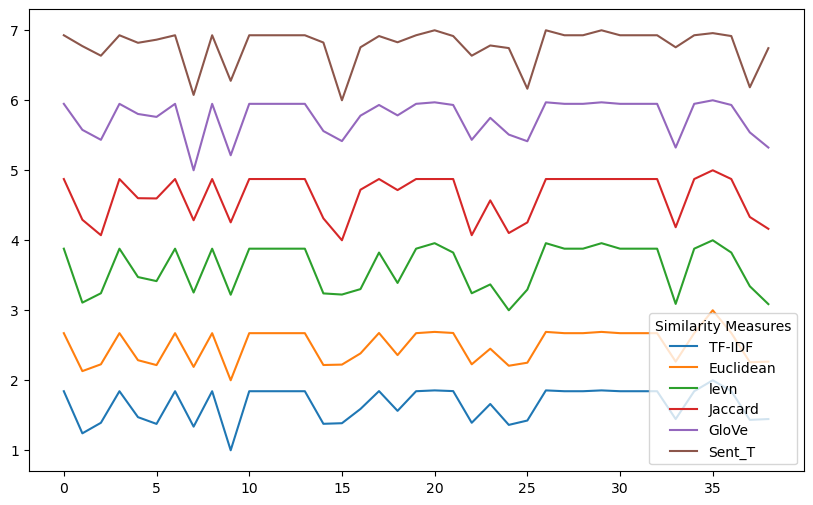

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
x = [i for i in range(len(sent_t))]  # Assuming sent_t is defined

# Set the figure size
plt.figure(figsize=(10, 6))  # Width, height in inches

# Create each lineplot
sns.lineplot(x=x, y=normalize_range(1,tfidf), label='TF-IDF')
sns.lineplot(x=x, y=normalize_range(2,euclidean), label='Euclidean')
sns.lineplot(x=x, y=normalize_range(3,levn), label='levn')
sns.lineplot(x=x, y=normalize_range(4,jaccard), label='Jaccard')
sns.lineplot(x=x, y=normalize_range(5,glove), label='GloVe')
sns.lineplot(x=x, y=normalize_range(6,sent_t), label='Sent_T')

# Add legend to the plot with a title
plt.legend(title='Similarity Measures')

# Show the plot
plt.show()

Time to compute cosine similarity: 0.028191 seconds
Time to compute cosine similarity: 0.005050 seconds
Time to compute cosine similarity: 0.004002 seconds
Time to compute cosine similarity: 0.002529 seconds
Time to compute cosine similarity: 0.003024 seconds
Time to compute cosine similarity: 0.003494 seconds
Time to compute cosine similarity: 0.001999 seconds
Time to compute cosine similarity: 0.004512 seconds
Time to compute cosine similarity: 0.002001 seconds
Time to compute cosine similarity: 0.003122 seconds
Time to compute cosine similarity: 0.004258 seconds
Time to compute cosine similarity: 0.003001 seconds
Time to compute cosine similarity: 0.003999 seconds
Time to compute cosine similarity: 0.003094 seconds
Time to compute cosine similarity: 0.003000 seconds
Time to compute cosine similarity: 0.004618 seconds
Time to compute cosine similarity: 0.003005 seconds
Time to compute cosine similarity: 0.003000 seconds
Time to compute cosine similarity: 0.003000 seconds
Time to comp

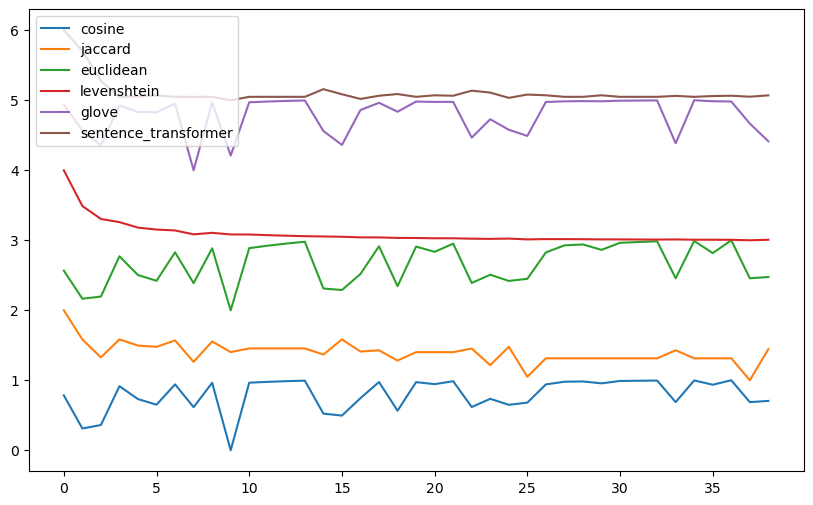

In [140]:
plt.figure(figsize=(10, 6))
for idx,method in enumerate(methods_list):
    sim_agg = calculate_similarity_with_aggregation(hard,method)
    diff = [sim_agg[i+1] - sim_agg[i] for i in range(len(sim_agg)-1)]
    diff = [0] + diff
    sns.lineplot(x=x, y=normalize_range(1*idx,sim_agg), label=method)  

In [139]:
calculate_similarity_with_aggregation(hard,'jaccard')

Time to compute jaccard similarity: 0.001602 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.000998 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001004 seconds
Time to compute jaccard similarity: 0.000999 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001999 seconds
Time to compute jaccard similarity: 0.000998 seconds
Time to compute jaccard similarity: 0.000999 seconds
Time to compute jaccard similarity: 0.001001 seconds
Time to compute jaccard similarity: 0.000507 seconds
Time to compute jaccard similarity: 0.000000 seconds
Time to compute jaccard similarity: 0.001015 seconds
Time to compute jaccard similarity: 0.000000 s

[0.9513888888888888,
 0.8205128205128205,
 0.7398843930635839,
 0.8208092485549133,
 0.7931034482758621,
 0.7873563218390804,
 0.8160919540229885,
 0.72,
 0.8114285714285714,
 0.7637362637362637,
 0.7802197802197802,
 0.7802197802197802,
 0.7802197802197802,
 0.7802197802197802,
 0.7527472527472527,
 0.8206521739130435,
 0.7663043478260869,
 0.7717391304347826,
 0.7258064516129032,
 0.7634408602150538,
 0.7634408602150538,
 0.7634408602150538,
 0.7795698924731183,
 0.7052631578947368,
 0.7875647668393783,
 0.6528497409326425,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.772020725388601,
 0.7357512953367875,
 0.7357512953367875,
 0.7357512953367875,
 0.6373056994818653,
 0.7772020725388601]

In [191]:
arr = np.array(['A', 'B' ,'C' ,'A' ,'A' ,'A']).reshape(1,-1)
arr

array([['A', 'B', 'C', 'A', 'A', 'A']], dtype='<U1')

In [192]:
consistency_checks = np.full(arr.shape, False, dtype=bool)
consistency_checks[:, 1:] = arr[:, 1:] == arr[:, :-1]
consistency_checks

array([[False, False, False, False,  True,  True]])

In [215]:
consistency_checks = np.full(arr.shape, False, dtype=bool)
buffer = [arr[0][0]]
for idx in range(1,consistency_checks.shape[1]):
    current_ans = arr[0][idx]
    pw_check = [current_ans == hist_ans for hist_ans in buffer]
    print(pw_check)
    consistency_checks[0][idx] = max(set(pw_check), key=pw_check.count)
    buffer.append(current_ans)

[False]
[False, False]
[True, False, False]
[True, False, False, True]
[True, False, False, True, True]


array([[False, False, False, False, False,  True]])

In [207]:
current_ans in buffer

False

In [1]:
def extract_cot_answer(df):
    tmp = []
    binary_correct = []
    for col in df.columns:
        if col.startswith('Final Answer_'):
            final_ans=df[col].to_numpy()
            correct_ans = [str(i) for i in df['Correct Answer']]
            correctness = final_ans == correct_ans
            tmp.append(final_ans)
            binary_correct.append(correctness)
    tmp_arr = np.vstack(tmp)
    binary_arr = np.vstack(binary_correct).T
    cot_answer_arr = tmp_arr.T
    return 0

In [8]:
import numpy as np
extract_cot_answer(hard)

(array([['A', 'A', 'A', ..., 'A', 'A', 'A'],
        ['B', 'B', 'C', ..., 'C', 'C', 'C'],
        ['ERROR', 'B', 'B', ..., 'B', 'B', 'B'],
        ...,
        ['A', "SCHINDLER'S LIST", 'A', ..., 'A', 'A', 'A'],
        ['THE GREEN MILE', 'THE GREEN MILE', 'ERROR', ...,
         'THE GREEN MILE', 'THE PIANIST', 'THE GREEN MILE'],
        ['NO', 'YES', 'YES', ..., 'NO', 'NO', 'NO']], dtype=object),
 array([[ True,  True,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        ...,
        [ True, False,  True, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ...,  True,  True,  True]]))

In [ ]:
def check_correctness_MC(correct_answer,cot_answers,question):
    correctness_list = []
    for i in range(len(cot_answers)):
        correct = correct_answer
        cot = cot_answers[i]
        q = question
        cot = str(cot)
        if (cot == correct):
            correctness_list.append(1)
            continue
        # Extract the options and their corresponding values from the question
        options = {}
        for option in ['a', 'b', 'c', 'd', 'e']:
            if option + ' )' in q:
                value = q.split(option + ' )')[-1].strip().split(',')[0].strip()
                options[option] = value
        if options[correct] in cot:
            correctness_list.append(1)
        else:
            correctness_list.append(0)

    return correctness_list